# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Fake Job Detection using NLP</p>

##  <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Goal: Detecting Fake Job Postings posted in the different job portals</p>

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Import Libraries </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string 

import contractions # I'm you'r etc
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer

from tqdm import tqdm # printing the status bar
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">1. Read Data </p>

In [2]:
import requests
from io import BytesIO
from zipfile import ZipFile

# Define the URL of the zip file
zip_url = "https://github.com/alberto2020china/fake_jobs/raw/main/data/fake_job_postings.csv.zip"

# Send a GET request to the URL
response = requests.get(zip_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Extract the content of the zip file
    with ZipFile(BytesIO(response.content)) as zip_file:
        # Specify the file you want to extract from the zip archive
        file_to_extract = "fake_job_postings.csv"

        # Extract the file and load it into a Pandas DataFrame (assuming it's a CSV file)
        with zip_file.open(file_to_extract) as file:
            # Now you can use the file (e.g., load it into a Pandas DataFrame)
            # For example:
            # import pandas as pd
            df_raw = pd.read_csv(file)
            print(f"{file_to_extract} has been successfully loaded.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

fake_job_postings.csv has been successfully loaded.


In [3]:
df_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
#data = pd.read_csv("data/fake_job_postings.csv")
data = df_raw.copy()
print("Shape: ", data.shape)

data.head()

Shape:  (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df = data.copy()

#### Basic Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
df.describe(include = "all")

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
count,17880.000000,17880,17534,6333,2868,14572,17879,15184,10668,17880.000000,17880.000000,17880.000000,14409,10830,9775,12977,11425,17880.000000
unique,NaN,11231,3105,1337,874,1709,14801,11967,6204,NaN,NaN,NaN,5,7,13,131,37,NaN
top,NaN,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,NaN,NaN,NaN,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,NaN
freq,NaN,311,718,551,142,726,379,410,726,NaN,NaN,NaN,11620,3809,5145,1734,1749,NaN
mean,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042897,0.795302,0.491723,NaN,NaN,NaN,NaN,NaN,0.048434
std,5161.655742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202631,0.403492,0.499945,NaN,NaN,NaN,NaN,NaN,0.214688
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,4470.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,8940.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,13410.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [8]:
df.describe(exclude="object")

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.describe(exclude=np.number)

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17534,6333,2868,14572,17879,15184,10668,14409,10830,9775,12977,11425
unique,11231,3105,1337,874,1709,14801,11967,6204,5,7,13,131,37
top,English Teacher Abroad,"GB, LND, London",Sales,0-0,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,718,551,142,726,379,410,726,11620,3809,5145,1734,1749


there are many missing feature values, we will perform futhur checks

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">2. Data Checks to perform </p>
 - Check Missing values
 - Check Duplicates
 - Check data type
 - Check the number of unique values of each column
 - Check statistics of data set
 - Check various categories present in the different categorical column
 
 #### Missing values

In [10]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [11]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in df.columns if df[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(df[feature].isnull().mean() * 100,4), " % missing")

location 1.9351  % missing
department 64.5805  % missing
salary_range 83.9597  % missing
company_profile 18.5011  % missing
description 0.0056  % missing
requirements 15.0783  % missing
benefits 40.3356  % missing
employment_type 19.4128  % missing
required_experience 39.4295  % missing
required_education 45.33  % missing
industry 27.4217  % missing
function 36.1018  % missing


In [12]:
# Null valuse percentage greater than 10%
columns_with_null_values_total = (df.isnull().sum() / len(df)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

columns_with_null_values_percentage

salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
dtype: float64

<b>observation:</b> There are many missing feature values. The features salary_range, and department are missing more than 50%. 

Let's plot some diagram for this relationship with Target variable

In [13]:
#for feature in feature_na:
    #df_temp = df.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    #df_temp[feature] = np.where(df_temp[feature].isnull(), 1, 0)
    
    # let's calculate the mean Stroke where the information is missing or present
    #data.groupby(feature)["fraudulent"].count().plot.bar()
    #plt.title(feature)
    #plt.show()

 #### Duplicate values check

In [14]:
df.duplicated().sum()

0

In [15]:
print("***** Duplicate check Feature wise *****\n")
# Check Job description duplications
print("Description: ", df["description"].duplicated().sum())

# Check Job Title duplications
print("Title: ", df["title"].duplicated().sum())

***** Duplicate check Feature wise *****

Description:  3078
Title:  6649


There are duplicated Job desciption and title, this has to taken care during preprocessing stage

In [16]:
#Sorting data according to text in ascending order
sorted_data=df.sort_values('description', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data[sorted_data["description"].duplicated()]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
14118,14119,Experienced Dog Groomer - Costa Mesa,"US, CA, Costa Mesa",Grooming,NaN,NaN,"""Pride is a personal commitment. It is an att...",NaN,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
12007,12008,EXPERIENCED CAREGIVERS NEEDED TODAY!THE BEST P...,"US, CO, Denver",NaN,NaN,MISSION:GoldLeaf HomeCare is revolutionizing h...,"""We take great care of our CarePartners so the...",Required Qualification: Current CPR &amp; Firs...,GoldLeaf provides:* Competitive rates for care...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
11806,11807,EXPERIENCED CAREGIVERS NEEDED TODAY!THE BEST P...,"US, CO, denver",NaN,NaN,MISSION:GoldLeaf HomeCare is revolutionizing h...,"""We take great care of our CarePartners so the...",Current CPR &amp; First Aid 3 to 5 Years + of...,GoldLeaf provides:* Competitive rates for care...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
3030,3031,mobile apps for Android/iOS developer,"VN, 64,",NaN,NaN,NaN,#NAME?,- BA/BS degree or equivalent practical experi...,• Salary: negotiate based on candidate's capa...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Engineering,0
3951,3952,Senior Java Developer with Hadoop Exp,"US, OH, Dublin",NaN,NaN,i28 Technologies has demonstrated expertise in...,#NAME?,- 5 to 8 years of experience - 3 to 5 years o...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13398,13399,Super Marketing Specialist,"CA, ON, Toronto",NaN,NaN,NaN,“What do you want to be when you grow up?” you...,1. You have a killer marketing instinct2. You ...,NaN,0,0,0,Full-time,NaN,NaN,Information Technology and Services,Marketing,0
13402,13403,Super Marketing Specialist,"CA, ON, Toronto",NaN,NaN,NaN,“What do you want to be when you grow up?” you...,1. You have a killer marketing instinct2. You ...,NaN,0,0,0,Full-time,NaN,NaN,Information Technology and Services,Marketing,0
1823,1824,Data Entry,"US, WA, ARDENVOIR WA",NaN,NaN,NaN,•Prepares source data for computer entry by co...,"Skills/Qualifications: Organization, Typing, D...","Benefits: Health, Dental, Life and AD&amp;D In...",0,0,0,NaN,NaN,NaN,NaN,NaN,0
9992,9993,Inbound Sales Representatives,"US, NY, Farmingdale",NaN,NaN,"For over 20 years NAC Marketing Company, LLC d...",• Answering incoming calls and securing ord...,• 6 months work experience • High school...,"We believe in the philosophy ‘be healthy, live...",0,1,0,Full-time,Entry level,NaN,NaN,Sales,0


#### Check the number of unique values of each column

To better organize our data, let's divide our features into two types: 
1) categorical 

2) numerical.

In [17]:
feature_cat = df.select_dtypes(include = ["object"]).columns.to_list()
print("Categorical Features:", feature_cat)

print("\n")

feature_num = df.select_dtypes(exclude = ["object"]).columns.to_list()
print("Numerical Features:",feature_num)

Categorical Features: ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']


Numerical Features: ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']


In [18]:
print("Categorical Feature Uniqueness:")
print("*" * 60)
for feature in feature_cat:
    print('{}: Unique Count: {}\n {}\n'.format(feature, len(df[feature].unique()), df[feature].unique()))

Categorical Feature Uniqueness:
************************************************************
title: Unique Count: 11231
 ['Marketing Intern' 'Customer Service - Cloud Video Production'
 'Commissioning Machinery Assistant (CMA)' ...
 'Senior Financial Analyst (Retail) ' 'Account Director - Distribution '
 'Project Cost Control Staff Engineer - Cost Control Exp - TX']

location: Unique Count: 3106
 ['US, NY, New York' 'NZ, , Auckland' 'US, IA, Wever' ...
 'US, CA, los Angeles' 'CA, , Ottawa' 'GB, WSX, Chichester']

department: Unique Count: 1338
 ['Marketing' 'Success' nan ... 'Admin - Clerical' 'Administrative Dept'
 'Hospitality']

salary_range: Unique Count: 875
 [nan '20000-28000' '100000-120000' '120000-150000' '50000-65000'
 '40000-50000' '60-80' '65000-70000' '75-115' '75000-110000' '17000-20000'
 '16000-28000' '95000-115000' '15000-18000' '50000-70000' '45000-60000'
 '30000-40000' '70000-90000' '10000-14000' '50-110' '28000-45000'
 '0-34300' '35000-40000' '9-Dec' '44000-57000' '1

#### Plot Target Variable

In [19]:
df.fraudulent.value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

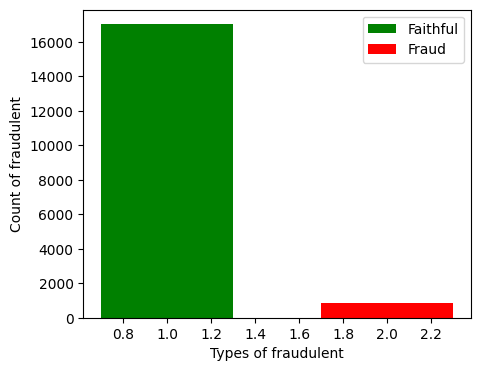

In [20]:
plt.rcParams['figure.figsize']=(5,4)
plt.bar(1,df[df["fraudulent"] == 0].count() ,width=0.6,label='Faithful',color='Green')
plt.legend()
plt.bar(2,df[df["fraudulent"] == 1].count(),width=0.6,label='Fraud',color='Red')
plt.legend()
plt.ylabel('Count of fraudulent')
plt.xlabel('Types of fraudulent')
plt.show()

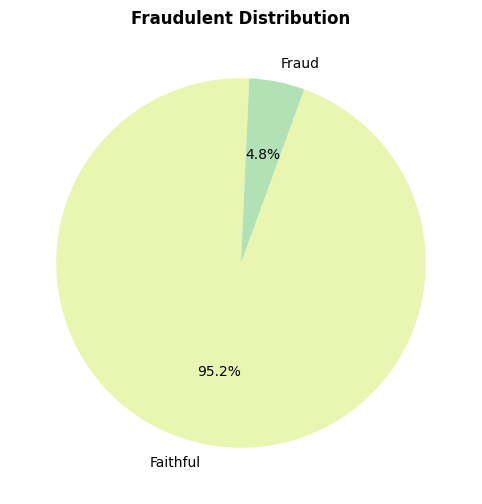

In [21]:
features_name = df['fraudulent'].value_counts().index
features_values = df['fraudulent'].value_counts().values

colors = sns.color_palette('YlGnBu')

plt.figure(figsize=(8, 6)) 
plt.pie(features_values, labels=features_name.map({1: "Fraud", 0:"Faithful"}), colors=colors, autopct='%1.1f%%', startangle=70, counterclock=False)

plt.title('Fraudulent Distribution', fontweight='bold')

plt.show()

<b>Observation:</b> The Target feature data is imbalanced. Ham is ~95% and Spam is ~ 5

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">3. Data preprocessing </p>
I just consider Description and Title features for basic model building.

In [22]:
df_train = df[["title","description","fraudulent"]]

print("Shape: ", df_train.shape)

Shape:  (17880, 3)


#### Fill or Remove missing value features features

In [23]:
df_train.isnull().sum()

title          0
description    1
fraudulent     0
dtype: int64

In [24]:
# There is just 1 missing value for description, so simply this can be dropped

df_train.dropna(subset=["description"], inplace=True)
print("Shape: ", df_train.shape)
df_train.isnull().sum()

Shape:  (17879, 3)


title          0
description    0
fraudulent     0
dtype: int64

#### Deduplication of data

In [25]:
df_train.duplicated().sum()

2093

In [26]:
df_train.drop_duplicates(keep="first", inplace= True)
print("Shape: ", df_train.shape)

df_train.duplicated().sum()

Shape:  (15786, 3)


0

### EDA
#### Description: Analyze the count of Charecters, Words, and Sentences in each segment - both Faithful, and Fraud

In [27]:
# No. of charecters in Description
df_train['desc_num_char'] = df_train['description'].apply(len)

# No. of of words in Description
df_train['desc_num_words'] = df_train['description'].apply(lambda x:len(nltk.word_tokenize(x)))

# No. of of sentences in Description
df_train['desc_num_sent'] = df_train['description'].apply(lambda x:len(nltk.sent_tokenize(x)))

df_train.head()

,title,description,fraudulent,desc_num_char,desc_num_words,desc_num_sent
0,Marketing Intern,"Food52, a fast-growing, James Beard Award-winn...",0,905,139,1
1,Customer Service - Cloud Video Production,Organised - Focused - Vibrant - Awesome!Do you...,0,2077,359,15
2,Commissioning Machinery Assistant (CMA),"Our client, located in Houston, is actively se...",0,355,57,3
3,Account Executive - Washington DC,THE COMPANY: ESRI – Environmental Systems Rese...,0,2600,384,6
4,Bill Review Manager,JOB TITLE: Itemization Review ManagerLOCATION:...,0,1520,203,2


In [28]:
df_train.describe(include=np.number)

,fraudulent,desc_num_char,desc_num_words,desc_num_sent
count,15786.000000,15786.000000,15786.000000,15786.000000
mean,0.042569,1255.182250,200.695046,5.275941
std,0.201891,901.769195,141.109617,4.343765
min,0.000000,6.000000,0.000000,0.000000
25%,0.000000,647.000000,106.000000,2.000000
50%,0.000000,1061.000000,172.000000,4.000000
75%,0.000000,1627.000000,261.000000,7.000000
max,1.000000,14907.000000,2448.000000,85.000000


In [29]:
# Faithful
df_train[df_train['fraudulent'] == 0][['desc_num_char','desc_num_words','desc_num_sent']].describe()

,desc_num_char,desc_num_words,desc_num_sent
count,15114.000000,15114.000000,15114.000000
mean,1257.319439,201.210930,5.260553
std,894.918170,140.059141,4.284373
min,6.000000,3.000000,1.000000
25%,656.250000,107.000000,2.000000
50%,1068.000000,173.000000,4.000000
75%,1627.000000,261.000000,7.000000
max,14907.000000,2448.000000,85.000000


In [30]:
# spam
df_train[df_train['fraudulent'] == 1].describe(include=np.number)

,fraudulent,desc_num_char,desc_num_words,desc_num_sent
count,672.0,672.000000,672.000000,672.000000
mean,1.0,1207.114583,189.092262,5.622024
std,0.0,1043.658444,162.644476,5.505720
min,1.0,9.000000,0.000000,0.000000
25%,1.0,467.750000,77.750000,2.000000
50%,1.0,873.500000,136.000000,4.000000
75%,1.0,1633.750000,260.250000,8.000000
max,1.0,8578.000000,1300.000000,45.000000


<b>Plot the Counts</b>

In [31]:
def plot_count(positive,negative,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.distplot(negative,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.distplot(positive,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show() 

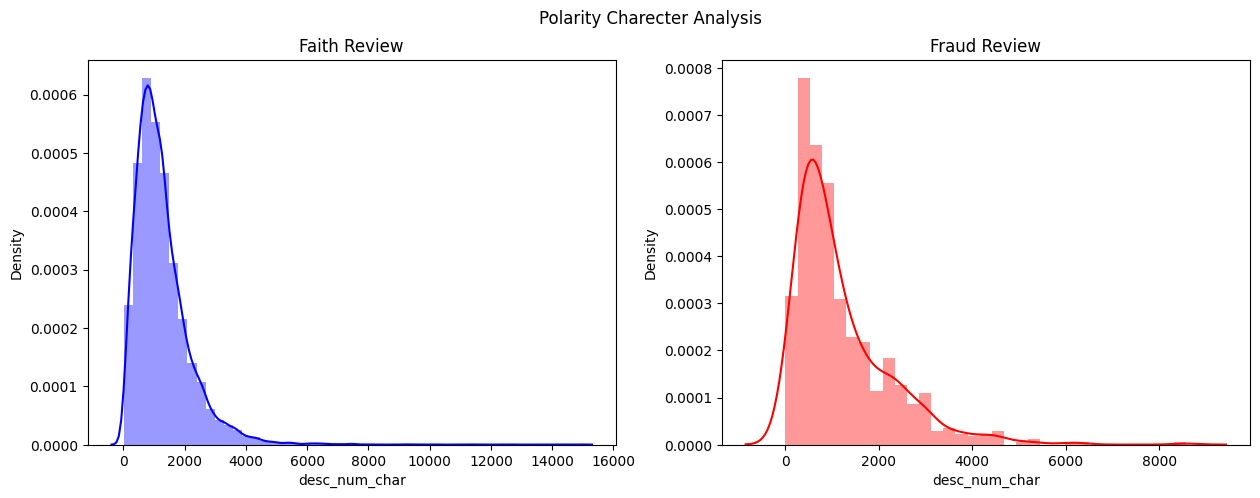

In [32]:
#Charecter Analysis
faith = df_train[df_train['fraudulent'] == 0]["desc_num_char"]
fraud = df_train[df_train['fraudulent'] == 1]["desc_num_char"]

plot_count(fraud, faith,"Faith Review","Fraud Review","Polarity Charecter Analysis")

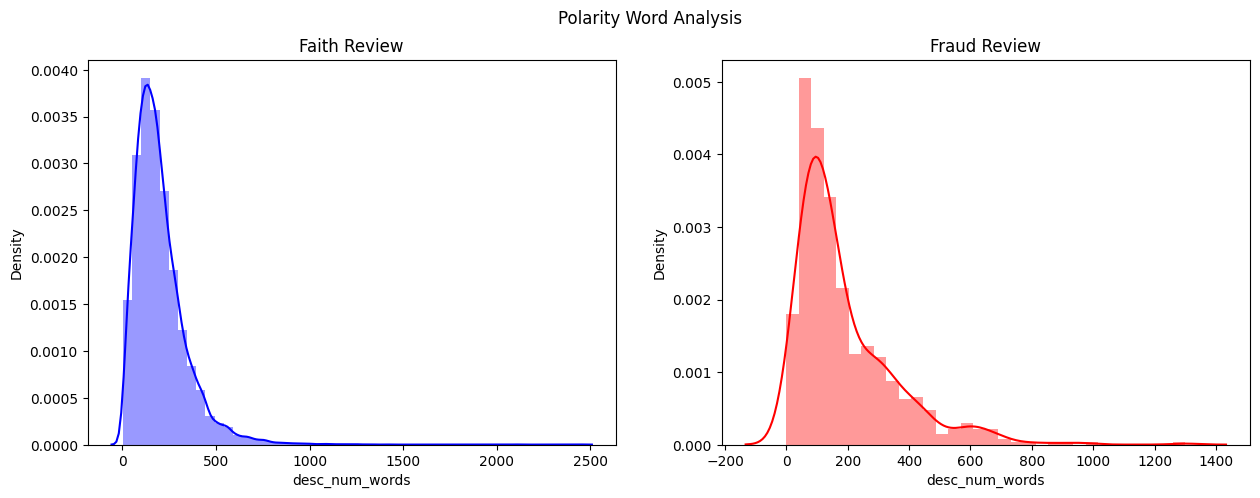

In [33]:
#Word Analysis
faith = df_train[df_train['fraudulent'] == 0]["desc_num_words"]
fraud = df_train[df_train['fraudulent'] == 1]["desc_num_words"]

plot_count(fraud, faith,"Faith Review","Fraud Review","Polarity Word Analysis")

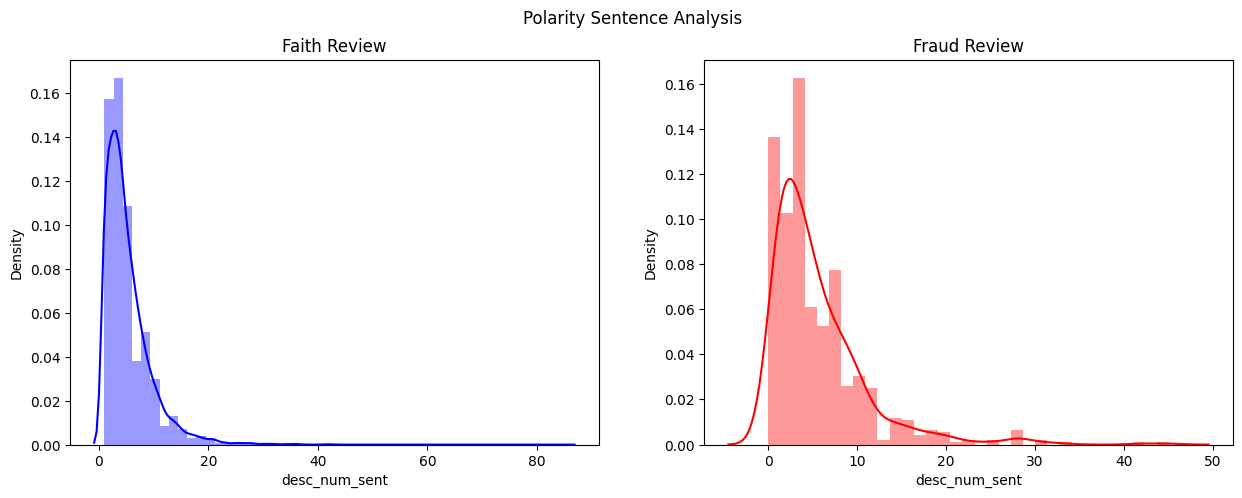

In [34]:
#Sentence Analysis
faith = df_train[df_train['fraudulent'] == 0]["desc_num_sent"]
fraud = df_train[df_train['fraudulent'] == 1]["desc_num_sent"]

plot_count(fraud, faith,"Faith Review","Fraud Review","Polarity Sentence Analysis")

The Fraud text is lengthy have more charecters, words, and sentences then Faith

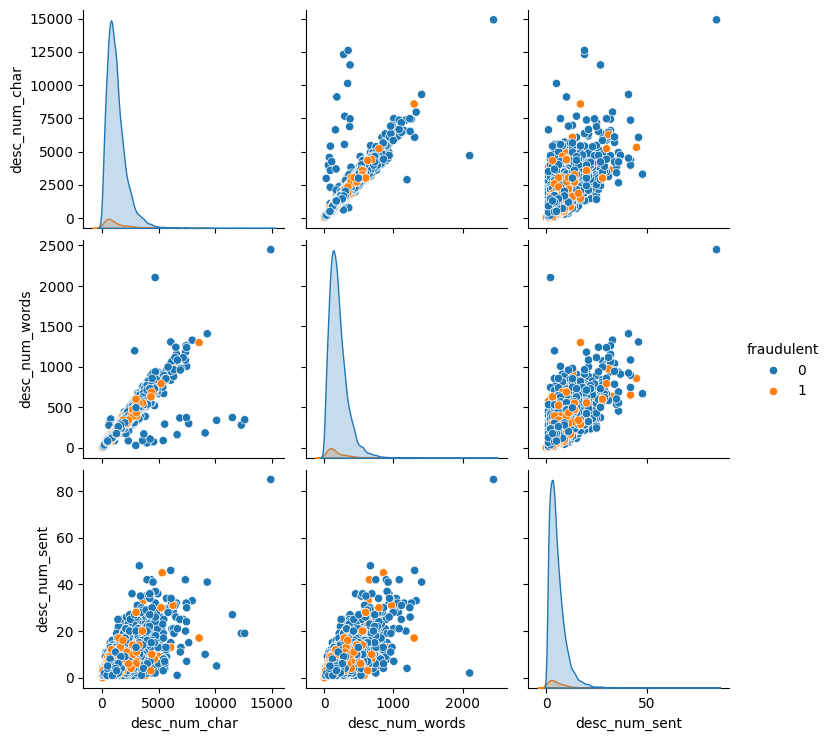

In [35]:
sns.pairplot(df_train,hue='fraudulent')

<Axes: >

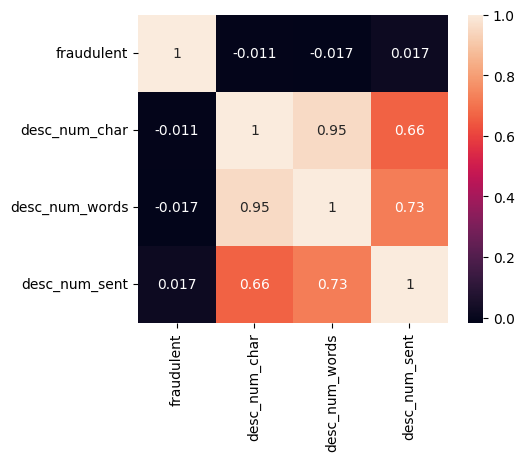

In [36]:
numCol = ["fraudulent", "desc_num_char", "desc_num_words", "desc_num_sent"]
sns.heatmap(df_train[numCol].corr(),annot=True)

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">4. Text preprocessing </p>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative type

In [37]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [38]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(corpus):
    preprocessed = []
    for sentance in tqdm(corpus):
        #sentance = re.sub(r"http+", "", sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)    
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed.append(sentance.strip())

    return preprocessed

In [39]:
%%time

df_train["desc_transformed"] = preprocess(df_train['description'].values)
df_train["title_transformed"] = preprocess(df_train['title'].values)

df_train["desc_transformed"][:5]


100%|██████████████████████████████████████████████████████████████████████████| 15786/15786 [00:03<00:00, 4032.77it/s]

CPU times: total: 15.4 s
Wall time: 15.4 s


0    fast growing james beard award winning online ...
1    organised focused vibrant awesome passion cust...
2    client located houston actively seeking experi...
3    company esri environmental systems research in...
4    job title itemization review managerlocation f...
Name: desc_transformed, dtype: object

In [40]:

ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

#Lemmatize the dataset
def lemma_traincorpus(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

In [41]:
#df_train["descr_transformed"] = df_train["description"].apply(transform_text)
#df_train.sample(10)

In [42]:
#df_train["descr_transformed"] = df_train["description"].apply(lemma_traincorpus)

#df_train.sample(10)

In [43]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

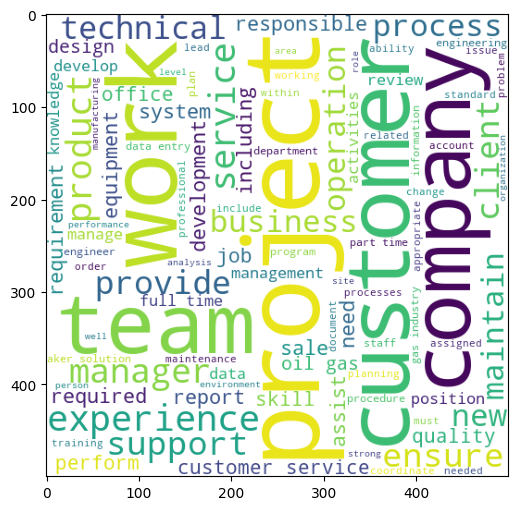

In [44]:
fraud_wc = wc.generate(df_train[df_train['fraudulent'] == 1]['desc_transformed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fraud_wc)

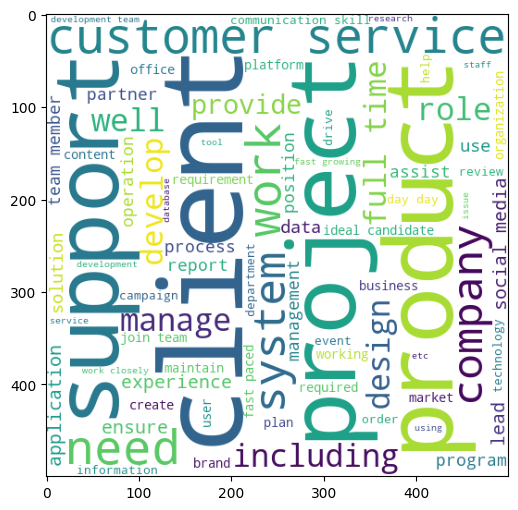

In [45]:
faith_wc = wc.generate(df_train[df_train['fraudulent'] == 0]['desc_transformed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(faith_wc)

In [46]:
fraud_corpus = []
for msg in df_train[df_train['fraudulent'] == 1]['desc_transformed'].tolist():
    for word in msg.split():
        fraud_corpus.append(word)
        
len(fraud_corpus)

73340

#### Fraud - 30 Most used words

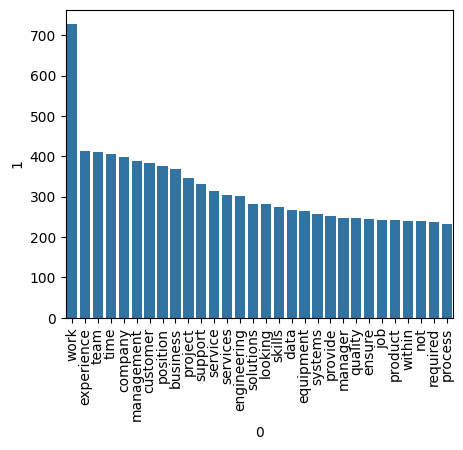

In [47]:
sns.barplot(x = pd.DataFrame(Counter(fraud_corpus).most_common(30))[0],
            y = pd.DataFrame(Counter(fraud_corpus).most_common(30))[1]
           )
plt.xticks(rotation='vertical')
plt.show()

In [48]:
faith_corpus = []
for msg in df_train[df_train['fraudulent'] == 0]['desc_transformed'].tolist():
    for word in msg.split():
        faith_corpus.append(word)
        
len(faith_corpus)

1709527

#### Faith - 30 Most used words

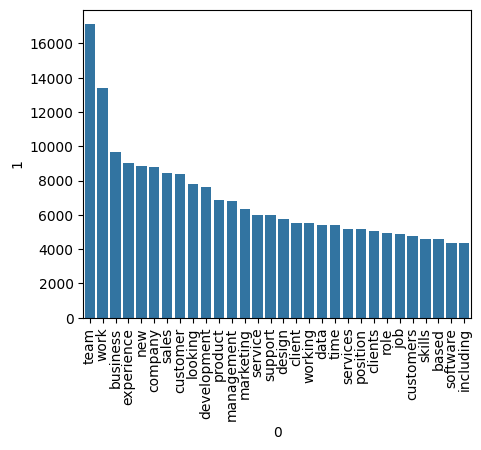

In [49]:
sns.barplot(x = pd.DataFrame(Counter(faith_corpus).most_common(30))[0],
            y = pd.DataFrame(Counter(faith_corpus).most_common(30))[1]
           )
plt.xticks(rotation='vertical')
plt.show()

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">5. Featurization </p>

#### BOW - Bag of words
Count Vectorization: This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.

In [50]:
preprocessed_desc = df_train["desc_transformed"]

In [52]:
%%time
##BoW
count_vect = CountVectorizer() 
count_vect.fit(preprocessed_desc)

print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aaa' 'aaahc' 'aac' 'aachen' 'aae' 'aaes' 'aafes' 'aalto' 'aan']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (15786, 56398)
the number of unique words  56398
CPU times: total: 4.27 s
Wall time: 4.37 s


#### Bi-Grams and n-Grams

In [53]:
%%time
#bi-gram, tri-gram and n-gram


count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (15786, 5000)
the number of unique words including both unigrams and bigrams  5000
CPU times: total: 6.41 s
Wall time: 6.44 s


#### TF-IDF
TF-IDF Vectorization: This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part

In [54]:
%%time

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10)
tf_idf_vect.fit(preprocessed_desc)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa' 'aac' 'aan' 'aan de' 'aan de slag' 'aan die' 'aan die de' 'aan het'
 'aan het bijwonen' 'ab']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15786, 48544)
the number of unique words including both unigrams and bigrams  48544
CPU times: total: 14.1 s
Wall time: 14.2 s


In [55]:
print("TF_IDF Shape: ", final_tf_idf.shape)

TF_IDF Shape:  (15786, 48544)


In [56]:
print(final_tf_idf[1])

  (0, 48145)	0.06563630448811032
  (0, 48144)	0.15662298670622077
  (0, 48071)	0.06284218749951573
  (0, 48065)	0.03683379268773119
  (0, 48044)	0.04766968950396062
  (0, 47963)	0.06563630448811032
  (0, 47850)	0.01883726377202527
  (0, 47391)	0.013701708979893182
  (0, 46635)	0.02885568632852346
  (0, 46238)	0.046461387990180764
  (0, 46234)	0.12476732518184742
  (0, 46231)	0.19498260518771043
  (0, 46230)	0.23209111362354762
  (0, 46216)	0.05503317653207741
  (0, 46209)	0.3175157500108445
  (0, 46197)	0.04475752269662378
  (0, 44887)	0.04956238072155607
  (0, 44192)	0.05660343991596783
  (0, 43995)	0.06499420172923681
  (0, 43869)	0.01863822520976183
  (0, 43667)	0.036060836166596125
  (0, 43635)	0.06633430992598607
  (0, 43634)	0.06284218749951573
  (0, 43629)	0.04485717617656062
  (0, 43009)	0.02506657925340143
  :	:
  (0, 4832)	0.06499420172923681
  (0, 4830)	0.05357059264377375
  (0, 4726)	0.051033855377427766
  (0, 4724)	0.06563630448811032
  (0, 4723)	0.06563630448811032
  (0, 